In [129]:
import pandas as pd
import scipy as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
import matplotlib.dates as mdates

from sklearn import linear_model

warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

%matplotlib inline

In [130]:
def get_csvs_paths(dataset_dir):
    result = {}
    for d, dirs, files in os.walk(dataset_dir):
        for name in files:
            if '.swp' in name:
                continue
            result[name] = dataset_dir + '/' + name
    
    return result

In [131]:
get_csvs_paths('final/train_us3')

{'abgw_detached_files.csv': 'final/train_us3/abgw_detached_files.csv',
 'abgw_detached_files_rate.csv': 'final/train_us3/abgw_detached_files_rate.csv',
 'abgw_fds.csv': 'final/train_us3/abgw_fds.csv',
 'abgw_io_limiting_failures_total.csv': 'final/train_us3/abgw_io_limiting_failures_total.csv',
 'abgw_iop_latency_ms_count.csv': 'final/train_us3/abgw_iop_latency_ms_count.csv',
 'abgw_iop_latency_ms_sum.csv': 'final/train_us3/abgw_iop_latency_ms_sum.csv',
 'abgw_read_bp.csv': 'final/train_us3/abgw_read_bp.csv',
 'abgw_read_reqs_total.csv': 'final/train_us3/abgw_read_reqs_total.csv',
 'abgw_write_bp.csv': 'final/train_us3/abgw_write_bp.csv',
 'abgw_write_reqs_total.csv': 'final/train_us3/abgw_write_reqs_total.csv',
 'abgw_write_rollback_bytes_total.csv': 'final/train_us3/abgw_write_rollback_bytes_total.csv',
 'detached.csv': 'final/train_us3/detached.csv',
 'fds.csv': 'final/train_us3/fds.csv'}

In [195]:
def extract_dataset(csv_path):
    df = pd.read_csv(csv_path)
    df['time'] = '2018_' + df['time']
    df['time'] = pd.to_datetime(df['time'], format='%Y_%d_%m_%H:%M')
    
    instances = pd.unique(df['instance'])
    
    return df, instances

write_reqs_df, instances = extract_dataset('final/train_us3/abgw_write_reqs_total.csv')
read_reqs_df, instances = extract_dataset('final/train_us3/abgw_read_reqs_total.csv')
latency_df, instances = extract_dataset('final/train_us3/abgw_iop_latency_ms_sum.csv')
latency_count_df, instances = extract_dataset('final/train_us3/abgw_iop_latency_ms_count.csv')
dtf_df, instances = extract_dataset('final/train_us3/abgw_detached_files_rate.csv')
dtf, instances = extract_dataset('final/train_us3/abgw_detached_files.csv')

In [196]:
write_node_0 = write_reqs_df[write_reqs_df['instance'] == instances[10]]
read_node_0 = read_reqs_df[read_reqs_df['instance'] == instances[10]]
latency_0 = latency_df[latency_df['instance'] == instances[10]]
latency_count_0 = latency_count_df[latency_count_df['instance'] == instances[10]]
dtf_0 = dtf_df[dtf_df['instance'] == instances[10]]
dttf = dtf[dtf['instance'] == instances[10]]

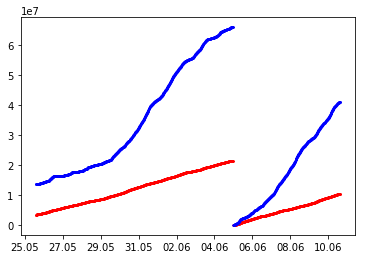

In [197]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d.%m"))
ax.plot(write_node_0['time'], write_node_0['abgw_write_reqs_total'], 'ro', markersize=1)
ax.plot(read_node_0['time'], read_node_0['abgw_read_reqs_total'], 'bo', markersize=1)
plt.show()

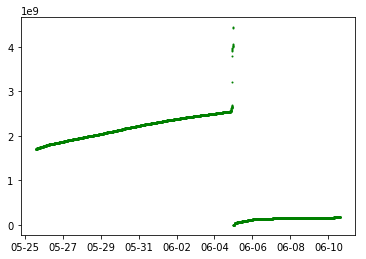

In [198]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
plt.plot(latency_0['time'], latency_0['abgw_iop_latency_ms_sum'], 'go', markersize=1)

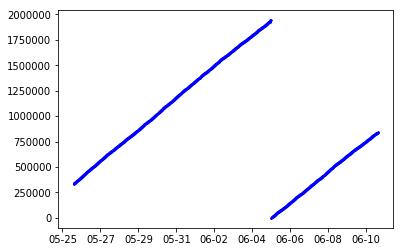

In [199]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
plt.plot(latency_count_0['time'], latency_count_0['abgw_iop_latency_ms_count'], 'bo', markersize=1)

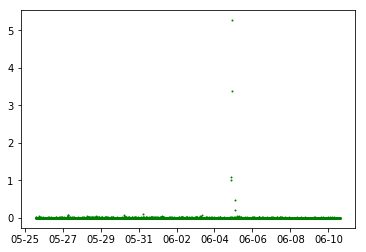

In [200]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
plt.plot(dtf_0['time'], dtf_0['abgw_detached_files_rate'], 'go', markersize=1)

In [201]:
req_df = pd.DataFrame()
req_df['read'] = read_node_0['abgw_read_reqs_total']
req_df['write'] = write_node_0['abgw_write_reqs_total']
req_df.head()

,read,write
120,13614429,3414294
121,13625425,3418527
122,13627455,3421827
123,13632961,3425327
124,13638357,3429410


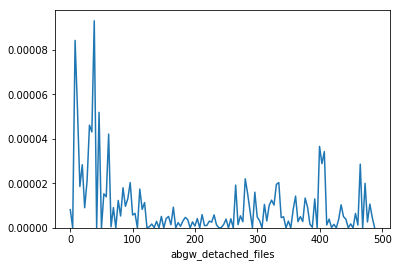

In [203]:
sns.distplot(dtf['abgw_detached_files'], hist=False)

In [205]:
req_df['total'] = req_df['read'] + req_df['write']
req_df['time'] = write_node_0['time']
req_df['latency'] = latency_0['abgw_iop_latency_ms_sum']
req_df['latency_count'] = latency_count_0['abgw_iop_latency_ms_count']
req_df['dtf_rate'] = dtf_0['abgw_detached_files_rate']
req_df['dtf'] = dtf['abgw_detached_files']
req_df[['write', 'read', 'latency', 'latency_count', 'dtf_rate', 'dtf']].corr()

,write,read,latency,latency_count,dtf_rate,dtf
write,1.000000,0.972827,0.998749,0.998198,0.052968,0.101255
read,0.972827,1.000000,0.977249,0.978234,0.052523,0.099311
latency,0.998749,0.977249,1.000000,0.999733,-0.219037,-0.124259
latency_count,0.998198,0.978234,0.999733,1.000000,-0.221585,-0.126660
dtf_rate,0.052968,0.052523,-0.219037,-0.221585,1.000000,0.469147
dtf,0.101255,0.099311,-0.124259,-0.126660,0.469147,1.000000


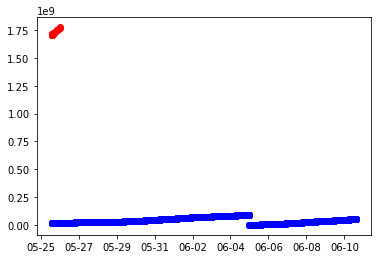

In [138]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
ax.plot(req_df['time'], req_df['total'], 'bo')
ax.plot(req_df['time'], req_df['latency'], 'ro')
plt.show()

In [207]:
req_df.shape[0]

4615